# Stim and position
## Is the direction-location specific stimulation system working correctly?

### Needs emk_neuro_analysis environment
### Loads LFP, camera tracking positions and DIO

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import itertools
from scipy.signal import sosfiltfilt, butter, hilbert
from scipy.stats import circstd

from emk_analysis import builder_experiment as bld_exp
from emk_neuro_analysis.lfp import iterator as lfp_iter
from emk_neuro_analysis.position import iterator as pos_iter
from mountainlab_pytools import mdaio
from emk_analysis import iterator as emk_iter

from scipy import signal
from pathlib import Path
from rec_to_binaries.read_binaries import readTrodesExtractedDataFile

## Experiment parameters

In [17]:
# name of experiment
experiment_name = 'clc'

experiment_phase = 'stim'

# data drive
data_disk = 'nvme1'

# directory with the preprocessed/extracted data files
dir_preprocess = f'/media/{data_disk}/Data/{experiment_name}/preprocessing/'

# Figure folder, where you want to save the output figures. Usually in your experiment folder for analysis.
dir_fig = f'/media/{data_disk}/Analysis/{experiment_name}/Results/'

# Location of track config file. 
# This is an excel spreadsheet that specifies the identities of the DIO for your experiment.
fname_config_track = (f'/media/{data_disk}/Data/{experiment_name}/config/Maze_YF_clc_Config.xlsx')

# Location of day records. 
# This is an excel spreadsheet that lists details for each session on your experiment day.
dir_records = (f'/media/{data_disk}/Data/{experiment_name}/dayrecords/')

# chose the date - as a list
choose_dates = [ '20220804',]

# choose the epoch - as a list
epoch_list = [1, 2, 3, 4, 5]

# choose the tetrodes - as a list
tet_list = [16, 19,]
# tet_list = [19,]

## Build day records from track confi file and experiment file

In [18]:
data_days = []
for curr_date in choose_dates:

    fname_day_record = f'{dir_records}{curr_date}_{experiment_phase}_training_record.xlsx'
    
    dict_sessions_day = bld_exp.build_day_from_file(experiment_name, 
                                track_config_file=fname_config_track,
                                day_record_file=fname_day_record)
    data_days.append(dict_sessions_day)

dict_sessions_all = bld_exp.build_all_sessions(data_days)
pprint(dict_sessions_all)

{'20220804_01': {'date': '20220804',
                 'description': 'maze stim',
                 'end': Timestamp('2022-08-04 23:55:00'),
                 'experiment': 'clc',
                 'id': 1,
                 'name': 'stim',
                 'start': Timestamp('2022-08-04 01:00:00'),
                 'tasks': {'Track 1': {'animal_id': '6004879',
                                       'description': 'Y',
                                       'dio': {'entry_sensor': {'bit': 11,
                                                                'notes': None,
                                                                'type': 'in'},
                                               'exit_sensor': {'bit': 12,
                                                               'notes': None,
                                                               'type': 'in'},
                                               'laser_pump': {'bit': 2,
                                              

## Load LFP Data

In [19]:
lfp_data, lfp_timestamp, _ = lfp_iter.iterate_lfp_load(dir_preprocess, 
                                                       tet_list, 
                                                       choose_dates, 
                                                       epoch_list=epoch_list, 
                                                       remove_movement_artifact=True,
                                                       filter_linenoise=False,
                                                       print_debug=False)

/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


Loaded /media/nvme1/Data/clc/preprocessing/20220804/20220804_clc_05_stim.LFP tet 16
Loaded /media/nvme1/Data/clc/preprocessing/20220804/20220804_clc_05_stim.LFP tet 19
remove movement artifact
remove movement artifact
remove movement artifact
remove movement artifact
Loaded /media/nvme1/Data/clc/preprocessing/20220804/20220804_clc_02_stim.LFP tet 16
Loaded /media/nvme1/Data/clc/preprocessing/20220804/20220804_clc_02_stim.LFP tet 19
remove movement artifact
remove movement artifact
remove movement artifact
remove movement artifact
Loaded /media/nvme1/Data/clc/preprocessing/20220804/20220804_clc_01_stim.LFP tet 16
Loaded /media/nvme1/Data/clc/preprocessing/20220804/20220804_clc_01_stim.LFP tet 19
remove movement artifact
remove movement artifact
remove movement artifact
remove movement artifact
Loaded /media/nvme1/Data/clc/preprocessing/20220804/20220804_clc_03_stim.LFP tet 16
Loaded /media/nvme1/Data/clc/preprocessing/20220804/20220804_clc_03_stim.LFP tet 19
remove movement artifact
rem

## Transform Time

In [20]:
dict_session_time = {}

fs_time = 30000
fs_filter = 1500

for i in lfp_timestamp.items():
    time_curr = i[1]
    dict_session_time.update({i[0]:{'timestamp':np.array(time_curr),
                                    'time':(np.array(time_curr) - time_curr[0])/fs_time}})

<IPython.core.display.Javascript object>


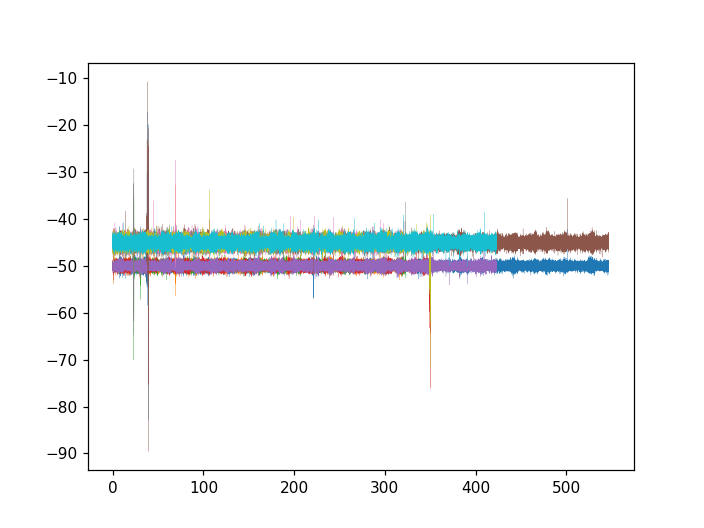

In [21]:
%matplotlib notebook

for i, (k, v) in enumerate(lfp_data.items()):
    for e in epoch_list:
        plt.plot((np.array(lfp_timestamp.get(e))-np.array(lfp_timestamp.get(e))[0])/fs_time,
                 np.array(v.get(e))/1000+5*(i-10), lw=.15)

## Import DIO Data

In [22]:
%matplotlib notebook

# print the plot on screen
plot_DIO = False

# remove DIO retriggers
filter_retrigger = 0

# time plotting settings
tick_minutes = mdates.MinuteLocator(interval=1)
tick_minutes_fmt = mdates.DateFormatter('%H:%M:%S.%f')
tick_minor = mdates.SecondLocator(interval=1)

# list dio to extract
# make sure these numbers match your DIOs
list_dio = [2, 13,]

# Specify parameters
# replace the key with your DIO number
# replace the 'pump': 'laser_pump' with your dio identity
dict_sensor_pump_map = {1: {'sensor': 'reward_1_sensor',
                           'pump': 'reward_1_pump'},
                       2: {'sensor': 'reward_2_sensor',
                           'pump': 'reward_2_pump'},
                       3: {'sensor': 'reward_3_sensor',
                           'pump': 'reward_3_pump'},}

y_label = ['stim',
           'reward_1',]

# plot each session
# get data for each animal
# initiate output
dict_dio_out = {}

dict_dio_in = {}

dict_trial_reward = {}

for animal_id in ['6004879']:
    
    print(animal_id)
    
    cls_behavior = emk_iter.ProcessBehavior(dict_sessions_all,
                                            experiment_name, trodes_version=3)
    cls_behavior.filter_animals(animal_id)
    dict_rewards = cls_behavior.count_reward_delivered()
    
    if not dict_rewards:
        continue
        
    df_pump = cls_behavior.report_reward_delivered(remove_zeroth=False,
                                                   output_raw=False,
                                                   filter_retrigger=None)
    
    df_sensor = cls_behavior.report_triggers(remove_zeroth=False,
                                             output_raw=False,
                                             filter_retrigger=filter_retrigger)
    
    df_reward = cls_behavior.report_trigger_reward(dict_sensor_pump_map)
    
    # get unique sessions
    sessions_unique = np.sort(df_sensor['session'].unique())
    print(sessions_unique)
    n_subplots = len(sessions_unique)
    
    if plot_DIO:
        fig = plt.figure(figsize=(10, n_subplots*3+2))
        axs = fig.subplots(n_subplots, 1)
        if n_subplots == 1:
            axs = [axs, ]
            sessions_unique = [sessions_unique[0], ]
            
    else:
        axs = [0]*len(sessions_unique)
        
    # divide into sessions
    for sn, (ax, session) in enumerate(zip(axs, sessions_unique)):
        
        # get session times
        curr_start = dict_sessions_all.get(session).get('start')
        curr_end = dict_sessions_all.get(session).get('end')
        
        # get sensor and pump times
        df_sensor_curr = df_sensor[df_sensor['session']==session]
        df_sensor_curr = df_sensor_curr[(df_sensor_curr['on_time_sys']>=curr_start)
                                       & (df_sensor_curr['on_time_sys']<curr_end)]
        df_pump_curr = df_pump[df_pump['session']==session]
        df_pump_curr = df_pump_curr[(df_pump_curr['on_time_sys']>=curr_start)
                                       & (df_pump_curr['on_time_sys']<curr_end)]
        
        df_reward_curr = df_reward[df_reward['session']==session]
        
        if int(session.split('_')[1]) in epoch_list:
        
            dict_dio_out.update({int(session.split('_')[1]): df_pump_curr})
            dict_dio_in.update({int(session.split('_')[1]): df_sensor_curr})
            dict_trial_reward.update({int(session.split('_')[1]): df_reward_curr})
        
        if not plot_DIO:
            continue
        
        for i, d in enumerate(list_dio):
            #print(d)
            yval = i+1
            curr_pump_name = dict_sensor_pump_map.get(d).get('pump')
            df_plot_pump = df_pump_curr[df_pump_curr['dio']==curr_pump_name]
            curr_sensor_name = dict_sensor_pump_map.get(d).get('sensor')
            df_plot_sensor = df_sensor_curr[df_sensor_curr['dio']==curr_sensor_name]
            # plot well triggers
            
            for ind, row in df_plot_sensor.iterrows():
                ax.scatter(row['on_time_sys'], yval+.3, s=25, c='k')
                
            for ind, row in df_plot_pump.iterrows():
                
                try:
                    ax.plot([row['on_time_sys'],
                             row['off_time_sys']], [yval+.15, yval+.15], c='r')
                
                except:
                    pass

6004879
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: F

/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
sensor Index(['on_time_sys', 'on_time', 'off_time_sys', 'off_time', 'duration', 'dio',
       'session', 'dio_bit'],
      dtype='object')
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

pump Index(['on_time_sys', 'on_time', 'on_state', 'off_time_sys', 'off_time',
       'off_state', 'duration', 'dio', 'session', 'dio_bit'],
      dtype='object')


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor['Rewarded'][i] = True
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor['Reward_on_time_sys'][i] = df_pump['on_time_sys'][curr_pump]
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the d

['20220804_01' '20220804_02' '20220804_03' '20220804_04' '20220804_05']


In [23]:
target_pump = 'ECU_Dout2'

dict_session_stim = {}

for item in dict_dio_out.items():
    
    df_pump_curr = item[1]
    key_curr = item[0]
    
    for i, d in enumerate(list_dio):
        # extract the wanted DIO data
        try:
            df_pump_curr_fltr = df_pump_curr[df_pump_curr['dio_bit']==target_pump]
            
            df_pump_on_timestamp = np.array(df_pump_curr_fltr.get('on_time'))
            df_pump_off_timestamp = np.array(df_pump_curr_fltr.get('off_time'))
            
            df_pump_on_time = (df_pump_on_timestamp - dict_session_time.get(key_curr).get('timestamp')[0])/fs_time
            df_pump_off_time = (df_pump_off_timestamp - dict_session_time.get(key_curr).get('timestamp')[0])/fs_time
            
            df_pump_length = np.array(df_pump_curr_fltr.get('duration')/np.timedelta64(1, 's'))*1000
            
            dict_session_stim.update({item[0]: pd.DataFrame({'on_timestamp':df_pump_on_timestamp,
                                                             'on_time':df_pump_on_time,
                                                             'off_timestamp':df_pump_off_timestamp,
                                                             'off_time':df_pump_off_time,
                                                             'len':df_pump_length})})
            
        except AttributeError:
            pass

In [24]:
target_sensor = 'ECU_Din13'

dict_session_sensor = {}

for item in dict_dio_in.items():

    df_sensor_curr = item[1]
    key_curr = item[0]
    
    for i, d in enumerate(list_dio):
        # extract the wanted DIO data
        try:
            df_sensor_curr_fltr = df_sensor_curr[df_sensor_curr['dio_bit']==target_sensor]
            
            df_sensor_on_timestamp = np.array(df_sensor_curr_fltr.get('on_time'))
            df_sensor_off_timestamp = np.array(df_sensor_curr_fltr.get('off_time'))
            
            df_sensor_on_time = (df_sensor_on_timestamp - dict_session_time.get(key_curr).get('timestamp')[0])/fs_time
            df_sensor_off_time = (df_sensor_off_timestamp - dict_session_time.get(key_curr).get('timestamp')[0])/fs_time
            
            df_sensor_length = np.array(df_sensor_curr_fltr.get('duration')/np.timedelta64(1, 's'))*1000
            
            dict_session_sensor.update({item[0]: pd.DataFrame({'on_timestamp':df_sensor_on_timestamp,
                                                               'on_time':df_sensor_on_time,
                                                               'off_timestamp':df_sensor_off_timestamp,
                                                               'off_time':df_sensor_off_time,
                                                               'len':df_sensor_length})})
            
        except AttributeError:
            pass

## Load position data

In [25]:
# this specifies the zoom factor on the camera
# needs to be measured 
# current setting of L17

cm_pix = {1: 0.3109,
          2: 0.05310,
          3: 0.3109,
          4: 0.05310,
          5: 0.3109,
          6: 0.05310,
          7: 0.3109,}

df_pos = pos_iter.iterate_pos_load(dir_preprocess, 
                                   date_list=choose_dates, 
                                   epoch_list=epoch_list, 
                                   cm_pix=cm_pix,
                                   print_debug=False)

4
Loaded /media/nvme1/Data/clc/preprocessing/20220804/20220804_clc_04_stim.1.pos
2
Loaded /media/nvme1/Data/clc/preprocessing/20220804/20220804_clc_02_stim.1.pos


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


5
Loaded /media/nvme1/Data/clc/preprocessing/20220804/20220804_clc_05_stim.1.pos
1
No pos data found in /media/nvme1/Data/clc/preprocessing/20220804/20220804_clc_01_stim.1.pos
3
Loaded /media/nvme1/Data/clc/preprocessing/20220804/20220804_clc_03_stim.1.pos


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


In [26]:
# divide position data into sessions

dict_session_pos = {}

for curr_epoch in epoch_list:
    dict_session_pos.update({curr_epoch: df_pos[df_pos.epoch == curr_epoch]})

## Raw Data Inspection

In [27]:
# %matplotlib notebook

# # sampling rate, convert raw timestamps to seconds on x-axis
# fs = 30000

# plt.figure()

# # speed
# plt.plot((np.array(df_pos.time) - time_data[0])/fs, df_pos.dxdydt_cm, zorder=-1, alpha=.4)

# # position
# # plt.plot(df_pos.time/fs, df_pos.xloc_smooth/10, zorder=-1, alpha=.4)
# plt.plot((np.array(df_pos.time) - time_data[0])/fs, df_pos.yloc_smooth/10, zorder=-1, alpha=.4)

# plt.xlabel('Time (s)')
# plt.ylabel('Speed (cm/s)')
# plt.tight_layout()

In [28]:
def replace_with_nearest(lst1, lst2):
    '''
    replace lst1 elements with their nearest elements
    in lst2
    '''
    return lst2[[np.abs(lst2 - e).argmin() for e in lst1]]

def get_timestamp_pos(df, lst):
    '''
    get the positions corresponding to timestamps
    '''
    return np.array([df.loc[df['time']==t, ['xloc_smooth', 'yloc_smooth']].values[0] 
                    for t in lst])

In [43]:
### SPECIFY tetrode used in each session
session_tet_map = {'20220725':
                   {1:1,
                    2:1,
                    3:1,
                    4:1,},
                   '20220726':
                   {1:1,
                    2:1,
                    3:1,
                    4:1,
                   },
                   '20220804':
                   {1:16,
                    2:16,
                    3:16,
                    4:19,
                    5:19},
                   '20220805':
                   {1:19,
                    2:19,
                    3:19,
                    4:19},
                  '20220810':
                   {1:19,
                    2:19,
                    3:19,
                    4:19},
                  '20220811':
                   {1:19,
                    2:19,
                    3:19,
                    4:19},
                   '20220812':
                   {1:19,
                    2:19,
                    3:19,
                    4:19,
                    5:19},}

### SELECT SESSION for analysis
session = 3

### initialize filter (range of detection)
target_lowcut = 7
target_highcut = 9
butter_filter = butter(1, [target_lowcut, target_highcut], 'bp', fs=fs_filter, output='sos')

### LFP DATA
raw = lfp_data[session_tet_map.get(choose_dates[0]).get(session)][session]
filtered = sosfiltfilt(butter_filter, raw)

### PHASE
phase = np.angle(hilbert(filtered)) + np.pi

### LFP TIME
time = dict_session_time.get(session).get('time')
timestamp = dict_session_time.get(session).get('timestamp')

### STIM TIME
df_stim = dict_session_stim.get(session)
df_stim_fltr = df_stim  # all stims
stim_time_raw = df_stim_fltr.get('on_time')
stim_timestamp_raw = replace_with_nearest(df_stim_fltr.get('on_timestamp'), 
                                          np.array(dict_session_pos.get(session).get('time')))

### REWARD TIME
# df_reward_time = sensor_time_dict.get(session)
# reward_on_time = df_reward_time.get('on_time')
# reward_length = df_reward_time.get('len')
# reward_on_timestamp = replace_with_nearest(df_reward_time.get('on_timestamp'), 
#                                            time_dict.get(session).get('timestamp'))
# reward_off_timestamp = replace_with_nearest(df_reward_time.get('off_timestamp'), 
#                                             time_dict.get(session).get('timestamp'))


### POSITION
epoch_pos = dict_session_pos.get(session)

In [44]:
### EXCLUDE stim events during reward events
# stim_reward_exclude = np.invert(np.isin(stim_timestamp_raw,
#                                 np.hstack([np.linspace(start, end, (end-start+1))
#                                 for start, end in zip(reward_on_timestamp, reward_off_timestamp)])))

# stim_time = stim_time_raw[stim_reward_exclude]
# stim_timestamp = stim_timestamp_raw[stim_reward_exclude]

# INCLUDE all events
stim_time = stim_time_raw
stim_timestamp = stim_timestamp_raw

## Session-wide Trajectory & Event Spatial Distribution

<IPython.core.display.Javascript object>


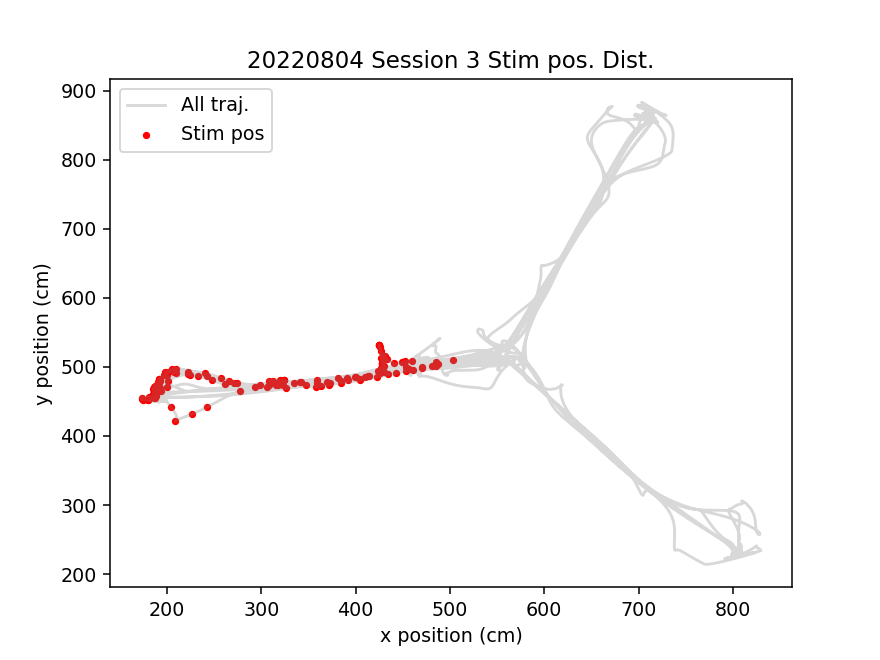

Text(0.5, 1.0, '20220804 Session 3 Stim pos. Dist.')

In [45]:
%matplotlib notebook

# Position data of ALL stim
stim_pos = get_timestamp_pos(epoch_pos, stim_timestamp)

# Session-wide trajectories
plt.plot(epoch_pos.get('xloc_smooth'), epoch_pos.get('yloc_smooth'), c='gray', alpha=.3, label='All traj.')

plt.scatter(stim_pos[:,0],stim_pos[:,1], s=8, c='r', alpha=1, label='Stim pos')

plt.legend()
plt.xlabel('x position (cm)')
plt.ylabel('y position (cm)')
plt.title(f'{choose_dates[0]} Session {session} Stim pos. Dist.')

## Seperate into Trials

In [33]:
def preprocess_epoch_reward(epoch_reward_raw):
    '''
    remove DIO retriggers, some rewarded others not
    '''
    epoch_reward_raw = epoch_reward_raw[epoch_reward_raw['Rewarded']]
    curr_well_id = epoch_reward_raw.iloc[0]['well_id']
    row_incl = [0]
    for i, (ind) in enumerate(np.arange(1, len(epoch_reward_raw))):
        # iterate from the second item to the last
        if epoch_reward_raw.iloc[ind]['well_id'] == curr_well_id:
            continue
        else:
            row_incl.append(ind)
            curr_well_id = epoch_reward_raw.iloc[ind]['well_id']
            
    return epoch_reward_raw.iloc[row_incl]

In [40]:
stim_well_id = 1
# trial_type = 'leaving'
trial_type = 'entering'
# trial_type = 'all' # show all trials

dict_trials_pos = {}
dict_trials_lfp = {}
dict_trials_stim = {}

epoch_reward_raw = dict_trial_reward.get(session)
epoch_reward = preprocess_epoch_reward(epoch_reward_raw)

for i, (ind) in enumerate(np.arange(0, len(epoch_reward)-1)):         
    
    if trial_type == 'leaving':
        ### leaving [stim_well_id] arm trials
        if epoch_reward.iloc[ind]['well_id'] != stim_well_id: continue
    elif trial_type == 'entering':
        try:
            ### entering [stim_well_id] arm trials
            if epoch_reward.iloc[ind+1]['well_id'] != stim_well_id: continue
        except KeyError: pass
    
    t_start = epoch_reward.iloc[ind]['on_time']
    t_end = epoch_reward.iloc[ind+1]['off_time']
    
    curr_pos = epoch_pos[(epoch_pos.time >= t_start) & (epoch_pos.time < t_end)]
    curr_lfp_timestamp_incl = (timestamp >= t_start) & (timestamp < t_end)
    curr_stim_timestamp_incl = (stim_timestamp >= t_start) & (stim_timestamp < t_end)

#     curr_lfp_data = {}
#     for k, v in epoch_lfp.items():
#         curr_lfp_data.update({k: v[curr_lfp_timestamp_incl]})

    dict_trials_pos.update({i+1: curr_pos})
    dict_trials_lfp.update({i+1: {'timestamps': timestamp[curr_lfp_timestamp_incl],
                                  'data': raw[curr_lfp_timestamp_incl]}})
    dict_trials_stim.update({i+1: {'timestamp': np.array(stim_timestamp[curr_stim_timestamp_incl]),
                                   'time': np.array(stim_time[curr_stim_timestamp_incl])}})
    
print(f'{trial_type} {stim_well_id}: included trials {list(dict_trials_pos.keys())}')

entering 1: included trials [1, 3, 5, 7, 9, 11]


## Trial Event Count Distribution

In [41]:
# %matplotlib notebook

# stim_count_hist, stim_count_edges = np.histogram([len(e.get('timestamp')) for e in dict_trials_stim], range(0,100))

# plt.bar(stim_count_edges[:-1],
#         stim_count_hist,)

# plt.ylabel('Lap count')
# plt.xlabel('Stim count')

## Trial-by-trial Trajectory & Event

<IPython.core.display.Javascript object>


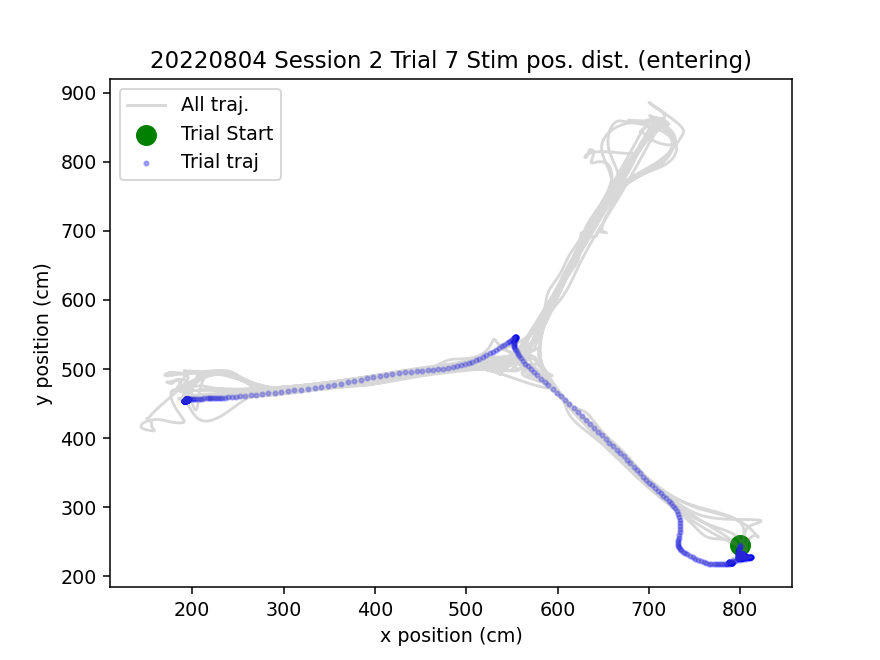

Text(0.5, 1.0, '20220804 Session 2 Trial 7 Stim pos. dist. (entering)')

In [42]:
# position distribution of stimulation
%matplotlib notebook

trial = 7
trial_pos = dict_trials_pos.get(trial)
trial_stim_pos = get_timestamp_pos(trial_pos, dict_trials_stim.get(trial).get('timestamp'))

# Session-wide trajectories
plt.plot(epoch_pos.get('xloc_smooth'), 
         epoch_pos.get('yloc_smooth'), 
         c='gray', alpha=.3, label='All traj.')

# mark trajectory starting point
plt.scatter(trial_pos.iloc[0].get('xloc_smooth'), 
            trial_pos.iloc[0].get('yloc_smooth'), 
            s=100, c='green', alpha=1, label='Trial Start')

# arrow to indicate travel direction
# plt.arrow(trial_pos.iloc[int(len(trial_pos)*0.6)].get('xloc_smooth'),
#           trial_pos.iloc[int(len(trial_pos)*0.6)].get('yloc_smooth'),
#           10, 10)

# trial trajectory
plt.scatter(trial_pos.get('xloc_smooth'), 
            trial_pos.get('yloc_smooth'), 
            s=5, c='b', alpha=.3, label='Trial traj')
try:
    # stim position
    plt.scatter(trial_stim_pos[:,0], 
                trial_stim_pos[:,1], s=8, 
                c='r', alpha=1, label='Stim pos')
except IndexError: pass

plt.legend()
plt.xlabel('x position (cm)')
plt.ylabel('y position (cm)')
plt.title(f'{choose_dates[0]} Session {session} Trial {trial} Stim pos. dist. ({trial_type})')

## Have-stim Percentage

In [267]:
have_stim_count = 0

for s in dict_trials_stim.values():
    if len(s.get('timestamp')) != 0: have_stim_count += 1

try:
    have_stim_perct = have_stim_count/len(dict_trials_stim)*100
except ZeroDivisionError:
    have_stim_perct = 0
    
print(f'{have_stim_perct:.2f}% of {trial_type} trials have stimulation event')

# -------------------------- SAVE DATA FOR FIGURES --------------------------

np.savetxt(f'{dir_fig}{choose_dates[0]}_{experiment_name}_{session}_{trial_type}_count.csv',
           np.array([have_stim_count, len(dict_trials_stim)]))

100.00% of leaving trials have stimulation event
